# Working with Hugging Face

Pixeltable provides seamless integration with Hugging Face datasets and models. This tutorial covers:

- Importing datasets directly into Pixeltable tables
- Working with dataset splits (train/test/validation)
- Streaming large datasets with `IterableDataset`
- Type mappings from Hugging Face to Pixeltable
- Using Hugging Face models for embeddings

## Setup

In [ ]:
%pip install -qU pixeltable datasets torch transformers

## Import a Hugging Face Dataset

Use `pxt.create_table()` with the `source=` parameter to import a Hugging Face dataset directly. Pixeltable automatically maps Hugging Face feature types to Pixeltable column types.

In [2]:
import pixeltable as pxt
import datasets

pxt.drop_dir('hf_demo', force=True)
pxt.create_dir('hf_demo')

# Load a dataset with images
padoru = (
    datasets.load_dataset("not-lain/padoru", split='train')
    .select_columns(['Image', 'ImageSize', 'Name', 'ImageSource'])
)

# Import into Pixeltable
images = pxt.create_table('hf_demo.images', source=padoru)

/opt/miniconda3/envs/pixeltable/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/pjlb/.pixeltable/pgdata
Created directory 'hf_demo'.


Generating train split: 100%|██████████| 382/382 [00:00<00:00, 2061.03 examples/s]


Created table 'images'.
Inserting rows into `images`: 100 rows [00:00, 321.91 rows/s]
Inserting rows into `images`: 100 rows [00:00, 365.93 rows/s]
Inserting rows into `images`: 100 rows [00:00, 375.77 rows/s]
Inserting rows into `images`: 82 rows [00:00, 601.27 rows/s]
Inserted 382 rows with 0 errors.


Image,ImageSize,Name,ImageSource
,240993,AI-Chan,https://knowyourmeme.com/photos/1439336-padoru
,993097,Platelet,https://knowyourmeme.com/photos/1438687-padoru
,255549,Nezuko Kamado,https://knowyourmeme.com/photos/1568913-padoru

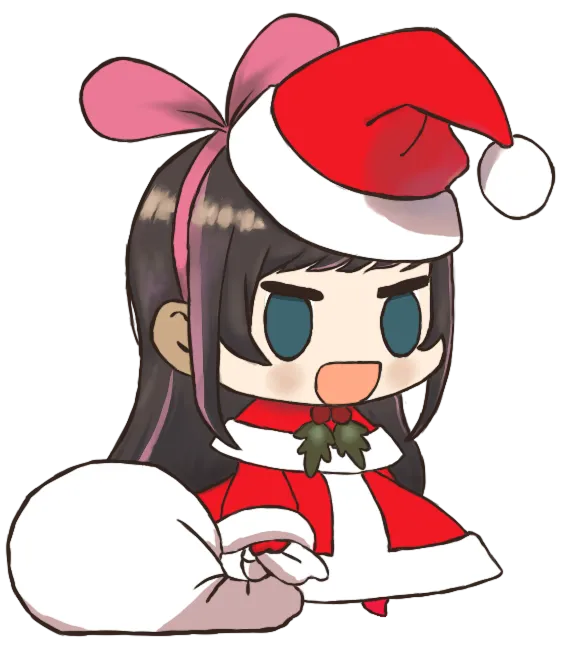
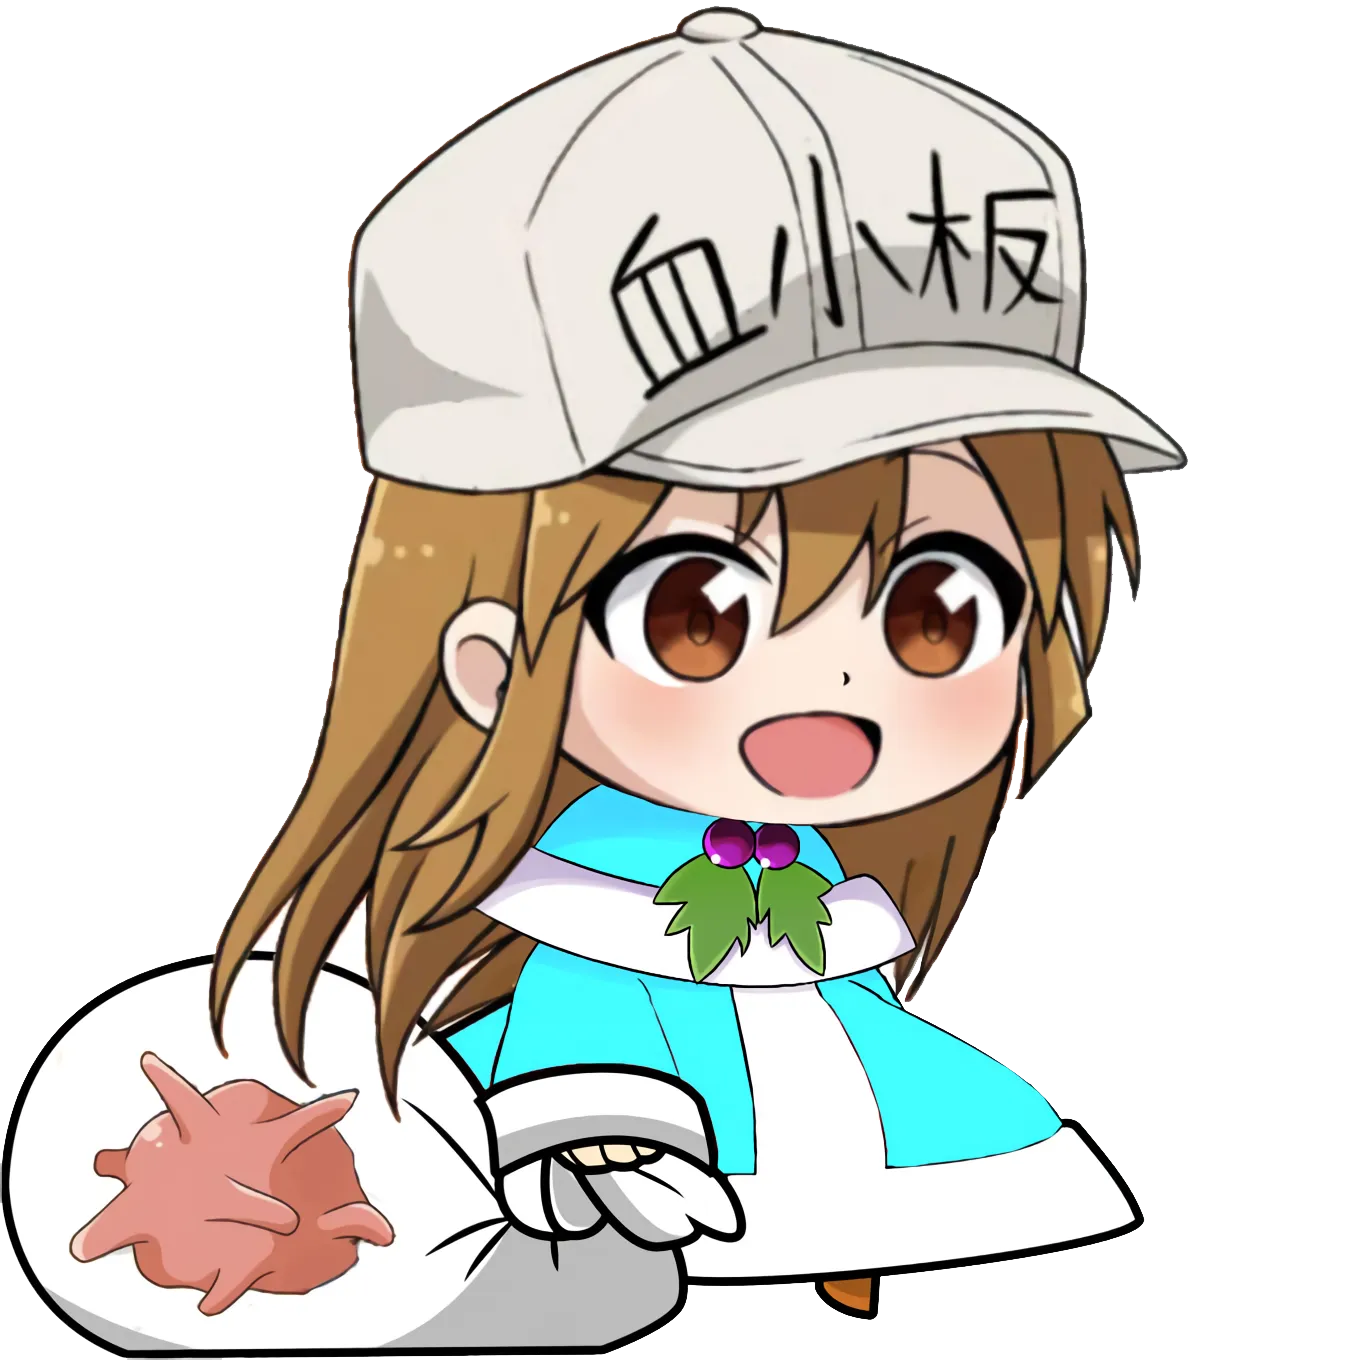
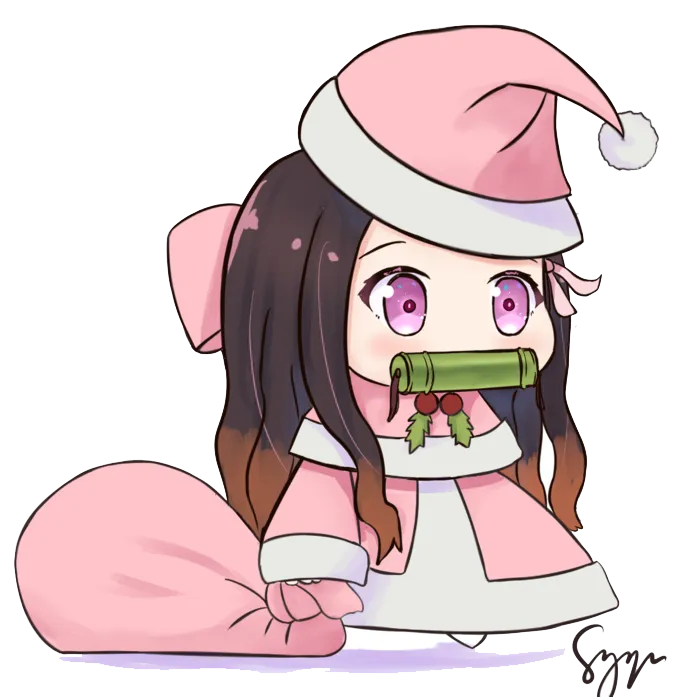

In [3]:
images.head(3)

## Working with Dataset Splits

When importing a `DatasetDict` (which contains multiple splits like train/test), you can either import each split separately or use `pxt.io.import_huggingface_dataset()` with `column_name_for_split` to combine them into one table.

In [ ]:
# Load a dataset with multiple splits
imdb = datasets.load_dataset('stanfordnlp/imdb')

# Option 1: Import all splits with split column using import_huggingface_dataset
reviews = pxt.io.import_huggingface_dataset(
    'hf_demo.reviews',
    imdb,
    column_name_for_split='split'
)

Generating unsupervised split: 100%|██████████| 50000/50000 [00:00<00:00, 944875.87 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [ ]:
# Option 2: Import each split separately with create_table
# train_reviews = pxt.create_table('hf_demo.train', source=imdb['train'])
# test_reviews = pxt.create_table('hf_demo.test', source=imdb['test'])

TypeError: create_table() got an unexpected keyword argument 'column_name_for_split'

In [ ]:
# Query by split
reviews.where(reviews.split == 'train').limit(3).select(reviews.text, reviews.label, reviews.split).collect()

In [ ]:
# Count rows per split
reviews.group_by(reviews.split).select(reviews.split, count=pxt.functions.count(reviews.text)).collect()

## Type Mappings

Pixeltable automatically converts Hugging Face feature types:

| HuggingFace Type | Pixeltable Type |
|------------------|------------------|
| `Value(bool)` | `Bool` |
| `Value(int*/uint*)` | `Int` |
| `Value(float*)` | `Float` |
| `Value(string)` | `String` |
| `Value(timestamp*)` | `Timestamp` |
| `ClassLabel` | `String` (label names) |
| `Sequence` of numerics | `Array` |
| `Array2D`-`Array5D` | `Array` |
| `Image` | `Image` |
| `Audio` | `Audio` |
| `Video` | `Video` |

Use `schema_overrides` to customize column types if needed.

## Streaming Large Datasets

For very large datasets, use `streaming=True` to create an `IterableDataset`. Pixeltable supports importing these without loading the entire dataset into memory.


In [ ]:
# Stream a large dataset (only fetches data as needed)
streaming_ds = datasets.load_dataset(
    'stanfordnlp/imdb',
    split='train',
    streaming=True
)

# Import first 100 rows from the stream
streaming_table = pxt.create_table('hf_demo.streaming_sample', source=streaming_ds.take(100))
streaming_table.count()


## Using Hugging Face Models for Embeddings

Pixeltable integrates with Hugging Face models for embeddings, running them locally without API keys.


In [ ]:
from pixeltable.functions.huggingface import clip

# Add CLIP embedding index for image similarity search
images.add_embedding_index(
    'Image',
    embedding=clip.using(model_id='openai/clip-vit-base-patch32')
)


In [ ]:
# Find similar images using text query (CLIP supports cross-modal search)
sim = images.Image.similarity('anime character with red hat')
images.order_by(sim, asc=False).limit(3).select(images.Image, images.Name, sim=sim).collect()


In [ ]:
# Image-to-image similarity search
sample_img = images.select(images.Image).head(1)[0]['Image']
sim = images.Image.similarity(sample_img)
images.order_by(sim, asc=False).limit(3).select(images.Image, images.Name, sim=sim).collect()


### Text Embeddings with Sentence Transformers


In [ ]:
from pixeltable.functions.huggingface import sentence_transformer

# Add text embedding index to a small sample
sample_reviews = pxt.create_table(
    'hf_demo.sample_reviews',
    source=datasets.load_dataset('stanfordnlp/imdb', split='test').select(range(100))
)

sample_reviews.add_embedding_index(
    'text',
    string_embed=sentence_transformer.using(model_id='all-MiniLM-L6-v2')
)


In [ ]:
# Semantic search
query = "great acting and cinematography"
sim = sample_reviews.text.similarity(query)

sample_reviews.order_by(sim, asc=False).limit(3).select(
    sample_reviews.text,
    sample_reviews.label,
    sim=sim
).collect()


## See Also

- [Import Hugging Face datasets cookbook](https://docs.pixeltable.com/howto/cookbooks/data/data-import-huggingface) - More import examples
- [Working with embedding indexes](https://docs.pixeltable.com/tutorials/embedding-indexes) - Index configuration
- [UDFs in Pixeltable](https://docs.pixeltable.com/tutorials/udfs-in-pixeltable) - Custom model integration
